In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation 
from tqdm import tqdm 
from scipy.fft import fft, ifft, fftfreq, fftshift 
from scipy import signal
from scipy.integrate import trapezoid, cumtrapz, solve_ivp
%matplotlib notebook

In [2]:
###functions for all calculation###
###spectrum of two signals###
def spec(s1, s2, time):
    fs1 = fft(s1) #fourier transform signal 1
    fs2 = fft(s2) #fourier transform signal 2
    freq_fs = fftfreq(len(time), d=(time[1] - time[0])) #frequency of the signals
    fs2_con = np.conj(fs2) #conjugate the signal 2
    spectrum = np.mean(fs1*fs2_con, axis=0)/len(time) #element of the spectrum --> [auto] when [s1 = s2]; [cross] when [s1 != s2]
    return spectrum, freq_fs

###[wilson algorithm] is used for factorizing the [spectral matrix] to [transfer matrix] and [covariance matrix of noise]###
#plus operator
def plus(g):
    m = g.shape[0]
    nw = g.shape[2]
    beta = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            beta[i,j,:] = ifft(g[i,j,:])
    betap = beta.copy()
    beta0 = 0.5*beta[:,:,0]
    betap[:,:,0] = np.triu(beta0) 
    betap[:,:,int(nw/2):] = 0 
    gp = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            gp[i,j,:] = fft(betap[i,j,:]) 
    return gp 

#wilson algorithm
def wilson(s, freq, ite, tol): #spectrum, frequency, iteration_number, accepted error
    m = s.shape[0] 
    nw = s.shape[2] 
    R = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            R[i,j,:] = ifft(s[i,j,:])
    psi = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        psi[:,:,i] = np.linalg.cholesky(R[:,:,0])
    g = np.zeros((m,m,nw))*(1+1j)
    I = np.eye(m,m)
    for t in range(0, ite, 1):
        for i in range(0, nw, 1):
            g[:,:,i] = np.linalg.inv(psi[:,:,i]) @ s[:,:,i] @ np.conj(np.linalg.inv(psi[:,:,i]).T)
            g[:,:,i] = g[:,:,i] + I 
        gp = plus(g)
        psi_old = psi.copy()
        psi_err = 0 
        for i in range(0, nw, 1):
            psi[:,:,i] = psi[:,:,i] @ gp[:,:,i]
            psi_err = psi_err + np.linalg.norm(psi[:,:,i] - psi_old[:,:,i])/nw
        if psi_err < tol: 
            break 
    A = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            A[i,j,:] = ifft(psi[i,j,:])
    A0 = A[:,:,0]
    cov = A0 @ A0.T
    H = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        H[:,:,i] = psi[:,:,i] @ np.linalg.inv(A0)
    freq_new = freq[int(len(freq)/2):] #included so that the frequency information is retained. 
    return H, cov, freq

###[transfer entropy] for one signal###
def cal_transfer(source, target, size, alpha):
    new_target = target[alpha+1:]
    old_target = target[:-1-alpha]
    old_source = source[:-1-alpha]
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size))
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size)
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size))
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size))
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 

###[transfer entropy] for all the simulation###
def all_cal_transfer(source, target, size, alpha, sim):
    new_target = target[:,alpha+1:].reshape((target[0,alpha+1:].shape[0]*sim))
    old_target = target[:,:-1-alpha].reshape((target[0,:-1-alpha].shape[0]*sim))
    old_source = source[:,:-1-alpha].reshape((source[0,:-1-alpha].shape[0]*sim))
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size))
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size)
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size))
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size))
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 

###Information rate###
def info_rate(pdfn, pdfo, axisn, axiso, timen, timeo):
    difx = axisn - axiso
    dift = (timen - timeo)**2
    pdf = (np.sqrt(pdfn) - np.sqrt(pdfo))**2
    #rate2 = 4*trapezoid(pdf, dx = difx/dift)
    rate2 = 4*np.sum(pdf * difx/dift)
    return rate2

In [3]:
###simulation of equations###
time = 25 #time of the series
fs = 200 #sampling frequency
tdata = np.arange(0, time, 1/fs) #array of time data
tdatapoint = len(tdata) #length of the time data
sim = 1000 #simulation number
c = 0.25*np.heaviside(list(tdata - 10), 1) #constantly give 0.25 times --> plot it to see. 

nmean = np.array([0.0, 0.0])
ncov = np.array([[1.0, 0.0],
                 [0.0, 1.0]]) 
x1noise, x2noise = np.random.multivariate_normal(nmean, ncov, size=(tdatapoint, sim)).T

x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))

for t in range(0, tdatapoint, 1):    
    x1[:, t] = 0.55*x1[:, t-1] - 0.8*x1[:, t-2] + c[t]*x2[:, t-1] + x1noise[:,t]
    x2[:, t] = 0.55*x2[:, t-1] - 0.8*x2[:, t-2] + x2noise[:,t]

<IPython.core.display.Javascript object>


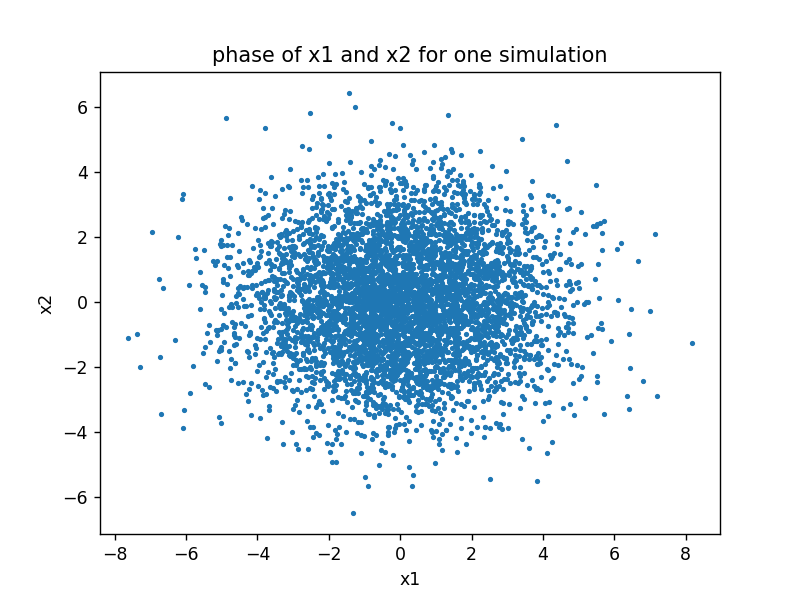

In [4]:
###plot of one of the [x1 and x2]###
plt.figure()
plt.plot(x1[0], x2[0], 'o', ms=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('phase of x1 and x2 for one simulation')
plt.show()

<IPython.core.display.Javascript object>


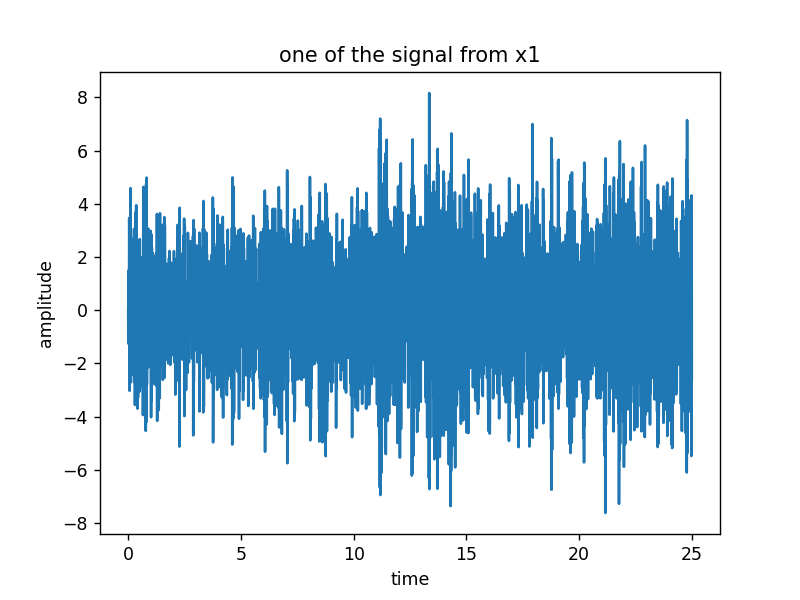

<IPython.core.display.Javascript object>


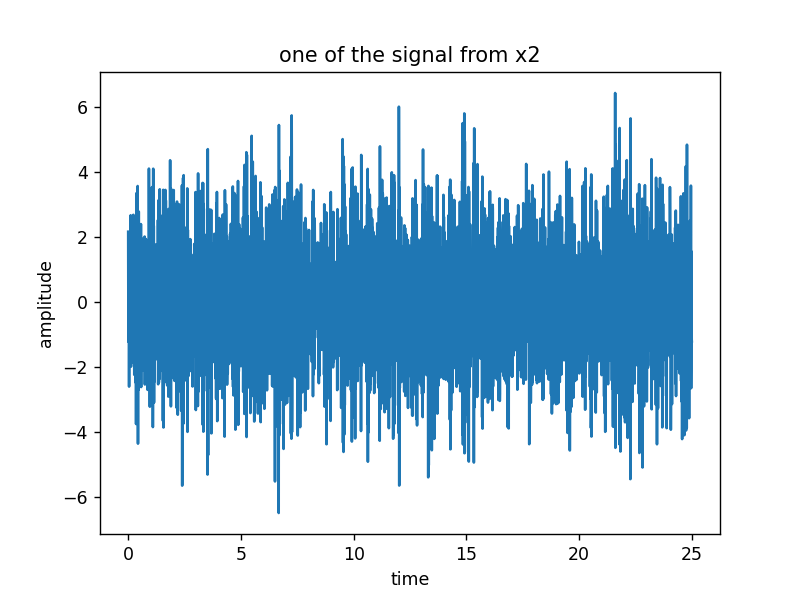

<IPython.core.display.Javascript object>


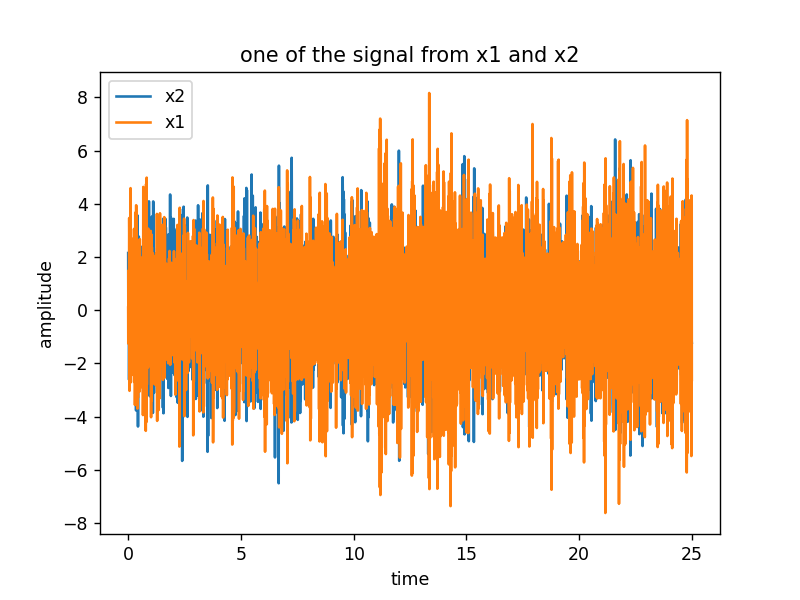

In [5]:
plt.figure()
plt.plot(tdata, x1[0], '-')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('one of the signal from x1')
plt.show()

plt.figure()
plt.plot(tdata, x2[0])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('one of the signal from x2')
plt.show()

plt.figure()
plt.plot(tdata, x2[0], label='x2')
plt.plot(tdata, x1[0], label='x1')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('one of the signal from x1 and x2')
plt.show()

In [6]:
######[granger causality frequency domain]######
###autospectrum and cross-spectrum###
fx1 = fft(x1) 
freq_fx1 = fftfreq(x1[0].size, d=1/fs)
fx1_con = np.conj(fx1) 

ans11 = np.mean(fx1*fx1_con, axis=0)/(len(tdata)) #autospectrum of s_{11}

#calculate the autospectrum of s_{22}
fx2 = fft(x2)
freq_fx2 = fftfreq(x2[0].size, d=1/fs)
fx2_con = np.conj(fx2)

ans22 = np.mean(fx2*fx2_con, axis=0)/(len(tdata)) #autospectrum of s_{22}

#calculate the cross-spectrum of s_{12} and s_{21}
ans12 = np.mean(fx1*fx2_con, axis=0)/(len(tdata)) #cross-spectrum of s_{12}
ans21 = np.mean(fx2*fx1_con, axis=0)/(len(tdata)) #cross-spectrum of s_{21}

#spectral matrix at every frequency 
s = np.array([[ans11, ans12],
              [ans21, ans22]])

#calculate the transfer function (H) and covariance matrix (covMat) 
H, covMat, freq = wilson(s, freq_fx1, 100, 1e-100) #1st parameter = spectral matrix; 2nd parameter = frequency; 3nd parameter = # iteration; 4th parameter = error of tolerance

#recalculate the spectral matrix / auto-&cross-spectrum after obtaining the [transfer function] and [covariance matrix]
spect = np.zeros((H.shape[0], H.shape[1], H.shape[2]))*(1+1j)
for t in range(H.shape[2]):
    temp = H[:,:,t] @ covMat @ np.conj(H[:,:,t].T)
    spect[:,:,t] = temp

#nonparametric granger causality and coherence calculation 
I21 = np.zeros(H.shape[2])*(1+1j) #signal 2 to signal 1
for i in range(H.shape[2]):
    Hbar11 = H[0,0,i] + covMat[0,1]/covMat[0,0] * H[0,1,i]
    temp = np.log((spect[0,0,i])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
    I21[i] = temp
    
I12 = np.zeros(H.shape[2])*(1+1j) #signal 1 to signal 2
for i in range(H.shape[2]):
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log((spect[1,1,i])/(Hhat22 * covMat[1,1] * np.conj(Hhat22)))
    I12[i] = temp
    
I12inst = np.zeros(H.shape[2])*(1+1j) #instantaneous of signal 1 and signal 2
for i in range(H.shape[2]):
    Hbar11 = H[0,0,i] + covMat[0,1]/covMat[0,0] * H[0,1,i]
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log(((Hbar11*covMat[0,0]*np.conj(Hbar11))*(Hhat22*covMat[1,1]*np.conj(Hhat22)))/(np.linalg.det(spect[:,:,i])))
    I12inst[i] = temp
    
Ispect = I21 + I12 + I12inst
cor = 1-np.exp(-Ispect) #coherence

<IPython.core.display.Javascript object>


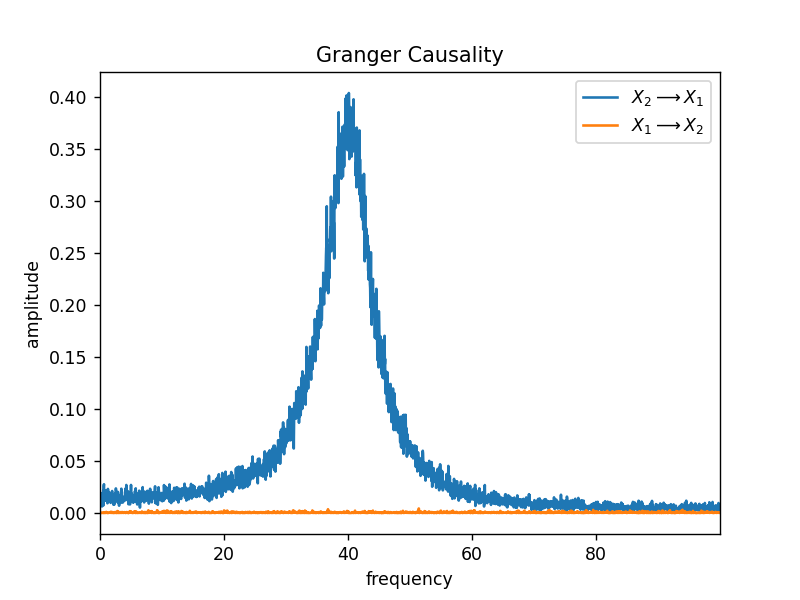

<IPython.core.display.Javascript object>


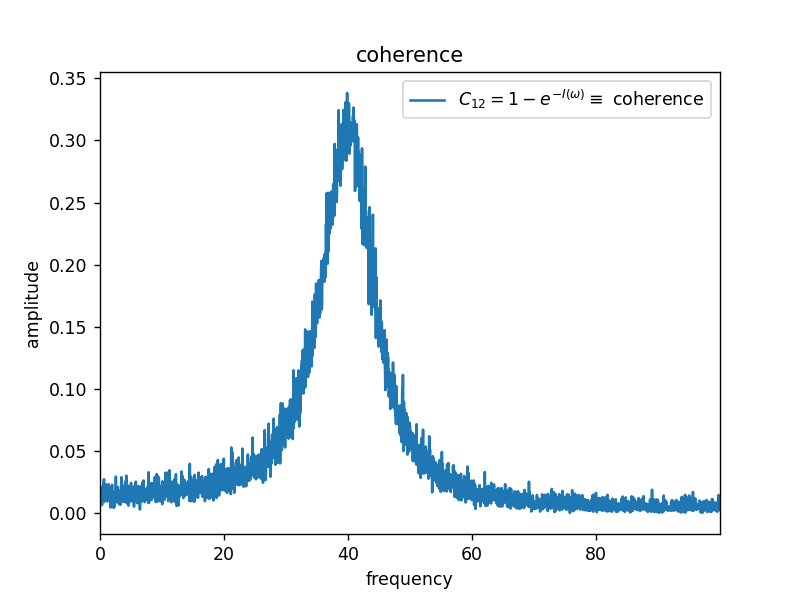

<IPython.core.display.Javascript object>


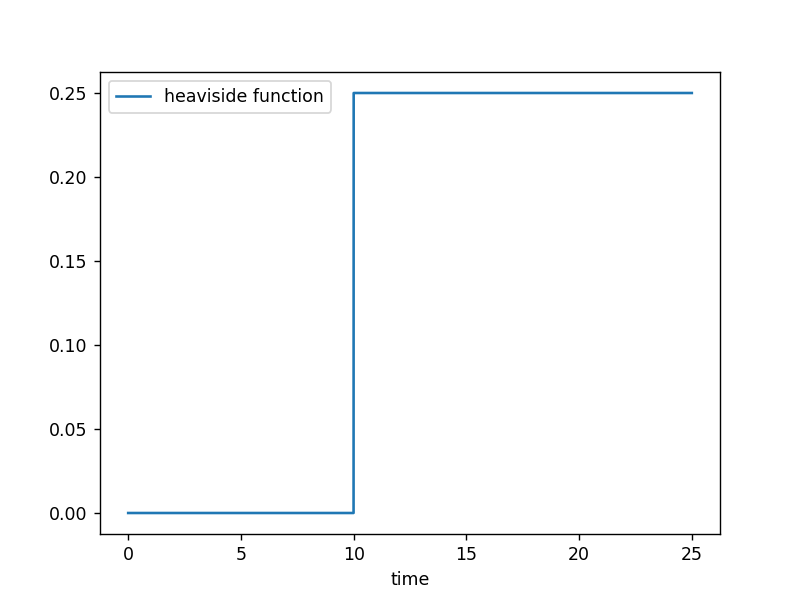

In [7]:
#non-parametric plot of granger causality
plt.figure()
plt.plot(fftshift(freq), fftshift(np.real(I21)), label='$X_2 \longrightarrow X_1$')
plt.plot(fftshift(freq), fftshift(np.real(I12)), label='$X_1 \longrightarrow X_2$')
#plt.plot(fftshift(freq), fftshift(np.real(I12inst)), label='$X_1 \longleftrightarrow X_2$')
plt.legend(loc='best')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('Granger Causality')
plt.xlim(0, np.max(fftshift(freq)))
plt.show()
plt.savefig('granger.png', dpi=100, bbox_inches='tight')

#non-parametric plot of coherence
plt.figure()
plt.plot(fftshift(freq), fftshift(np.real(cor)), label='$C_{12} = 1 - e^{-I(\omega)} \equiv$ coherence')
plt.legend(loc='best')
plt.xlim(0, np.max(fftshift(freq)))
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('coherence')
plt.show()

plt.figure()
plt.plot(tdata, c, label='heaviside function')
plt.legend(loc='best')
plt.xlabel('time')
plt.show()


From the graph, it shows that [x2] influences/gives information to [x1] at the rate of [40Hz]. However, in the setup [x2] only start to [x1] at time [t=10s], the exact [time] of [x2] influencing [x1] is not detected by just the [frequency plot]. 

In [8]:
######[granger causality] for [time] and [frequency]######
#composing the [spectral matrix]
sample = 256
overlap = 128
f1, t1, z1 = signal.stft(x1, fs, window='hann', nperseg=sample, noverlap=overlap)
f2, t2, z2 = signal.stft(x2, fs, window='hann', nperseg=sample, noverlap=overlap)
conj_z1 = np.conj(z1)
conj_z2 = np.conj(z2)

spec11 = np.mean(z1*conj_z1, axis=0)/(len(tdata))
spec12 = np.mean(z1*conj_z2, axis=0)/(len(tdata))
spec21 = np.mean(z2*conj_z1, axis=0)/(len(tdata))
spec22 = np.mean(z2*conj_z2, axis=0)/(len(tdata))

spec_total = np.array([[spec11, spec12],
                       [spec21, spec22]])

print(signal.check_COLA('hann', sample, overlap, tol=1e-10)) #checking for the suitable windowing for [short-time fourier transform] to ensure the matrix is [positive definite] for later calculation

I21 = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)
I12 = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)

for t in range(spec_total[0,0,0,:].size):
    H, covMat, freq = wilson(spec_total[:,:,:,t], f1, 40, 1e-15)
    for f in range(freq.size):
        Hbar11 = H[0,0,f] + covMat[0,1]*H[0,1,f]*covMat[0,0]
        temp2 = np.log((spec_total[0,0,f,t])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
        I21[t, f] = temp2
        
        Hhat22 = H[1,1,f] + (covMat[0,1])/(covMat[1,1]) * H[1,0,f]
        temp1 = np.log((spec_total[1,1,f,t])/(Hhat22 * covMat[1,1] *np.conj(Hhat22)))
        I12[t, f] = temp1

True


<IPython.core.display.Javascript object>


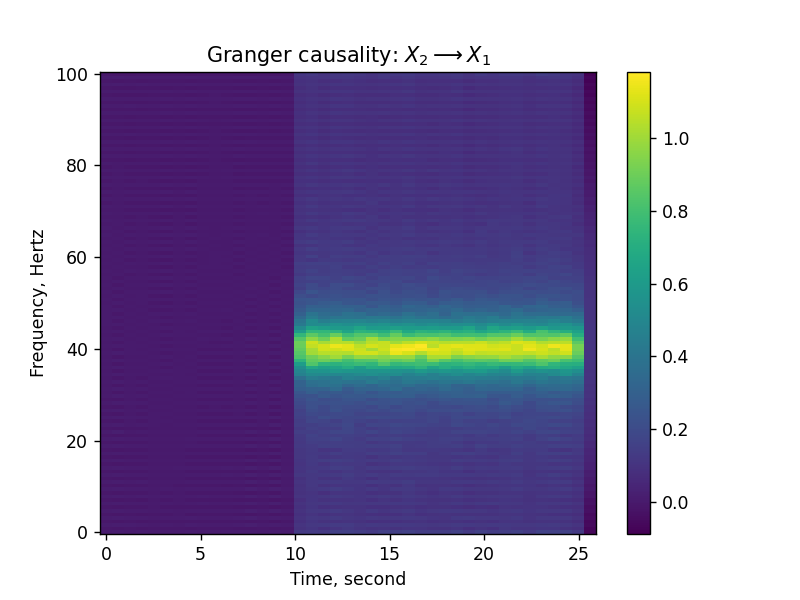

<IPython.core.display.Javascript object>


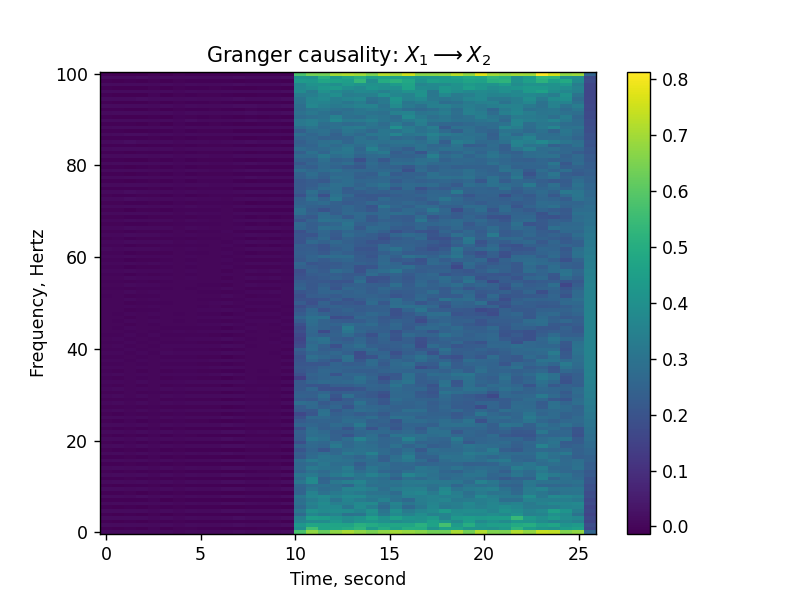

<IPython.core.display.Javascript object>


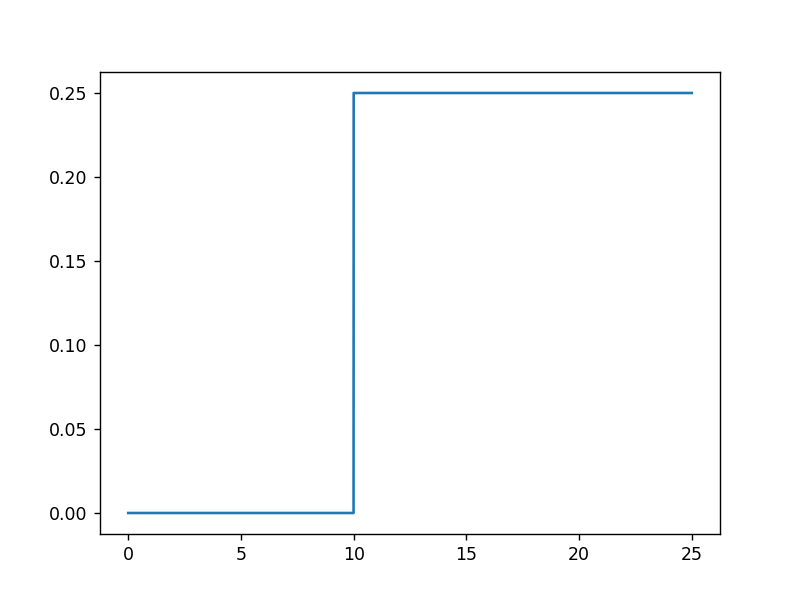

In [9]:
############################################################
plt.figure()
plt.pcolormesh(t2, f2, np.real(I21.T))
plt.xlabel('Time, second')
plt.ylabel('Frequency, Hertz')
plt.title('Granger causality: $X_2 \longrightarrow X_1$')
plt.colorbar()
#plt.xlim(0, 4.5)
plt.show()

############################################################
plt.figure()
plt.pcolormesh(t1, f1, np.real(I12.T))
plt.xlabel('Time, second')
plt.ylabel('Frequency, Hertz')
plt.title('Granger causality: $X_1 \longrightarrow X_2$')
plt.colorbar()
#plt.xlim(0, 4.5)
plt.show()

plt.figure()
plt.plot(tdata, c)
plt.show()

With the time-varying frequency domain, the influences from [x2] to [x1] can be correctly identified as shown. Note that the above result is obtained via [short time Fourier transfer], hence there is the present of "noises" for [x1] to [x2]; it will be good to conduct the analysis via [wavelet transform] instead. 

In [10]:
x1n = x1[:,:]
x2n = x2[:,:]
series = np.array([x1n, x2n])

range_past = 30 
transfer_matrix_series = np.zeros((range_past, len(series), len(series)))
range_t = []

for t in tqdm(range(range_past)):
    past = t
    size = 4
    
    x1n = x1[:,:]
    x2n = x2[:,:]
    series = np.array([x1n, x2n])
    transfer_matrix = np.zeros((len(series), len(series)))
    
    for i in range(len(series)):
        for j in range(len(series)):
            temp_trans1 = all_cal_transfer(series[i], series[j], size, past, sim)
            temp_trans2 = all_cal_transfer(series[j], series[i], size, past, sim)
            transfer_matrix_series[t, i, j] = (temp_trans1 - temp_trans2)
    range_t.append(past)
range_t = np.array(range_t)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\choongh2\AppData\Local\Temp\ipykernel_4736\469307606.py:113: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
C:\Users\choongh2\AppData\Local\Temp\ipykernel_4736\469307606.py:115: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.20s/it]


<IPython.core.display.Javascript object>


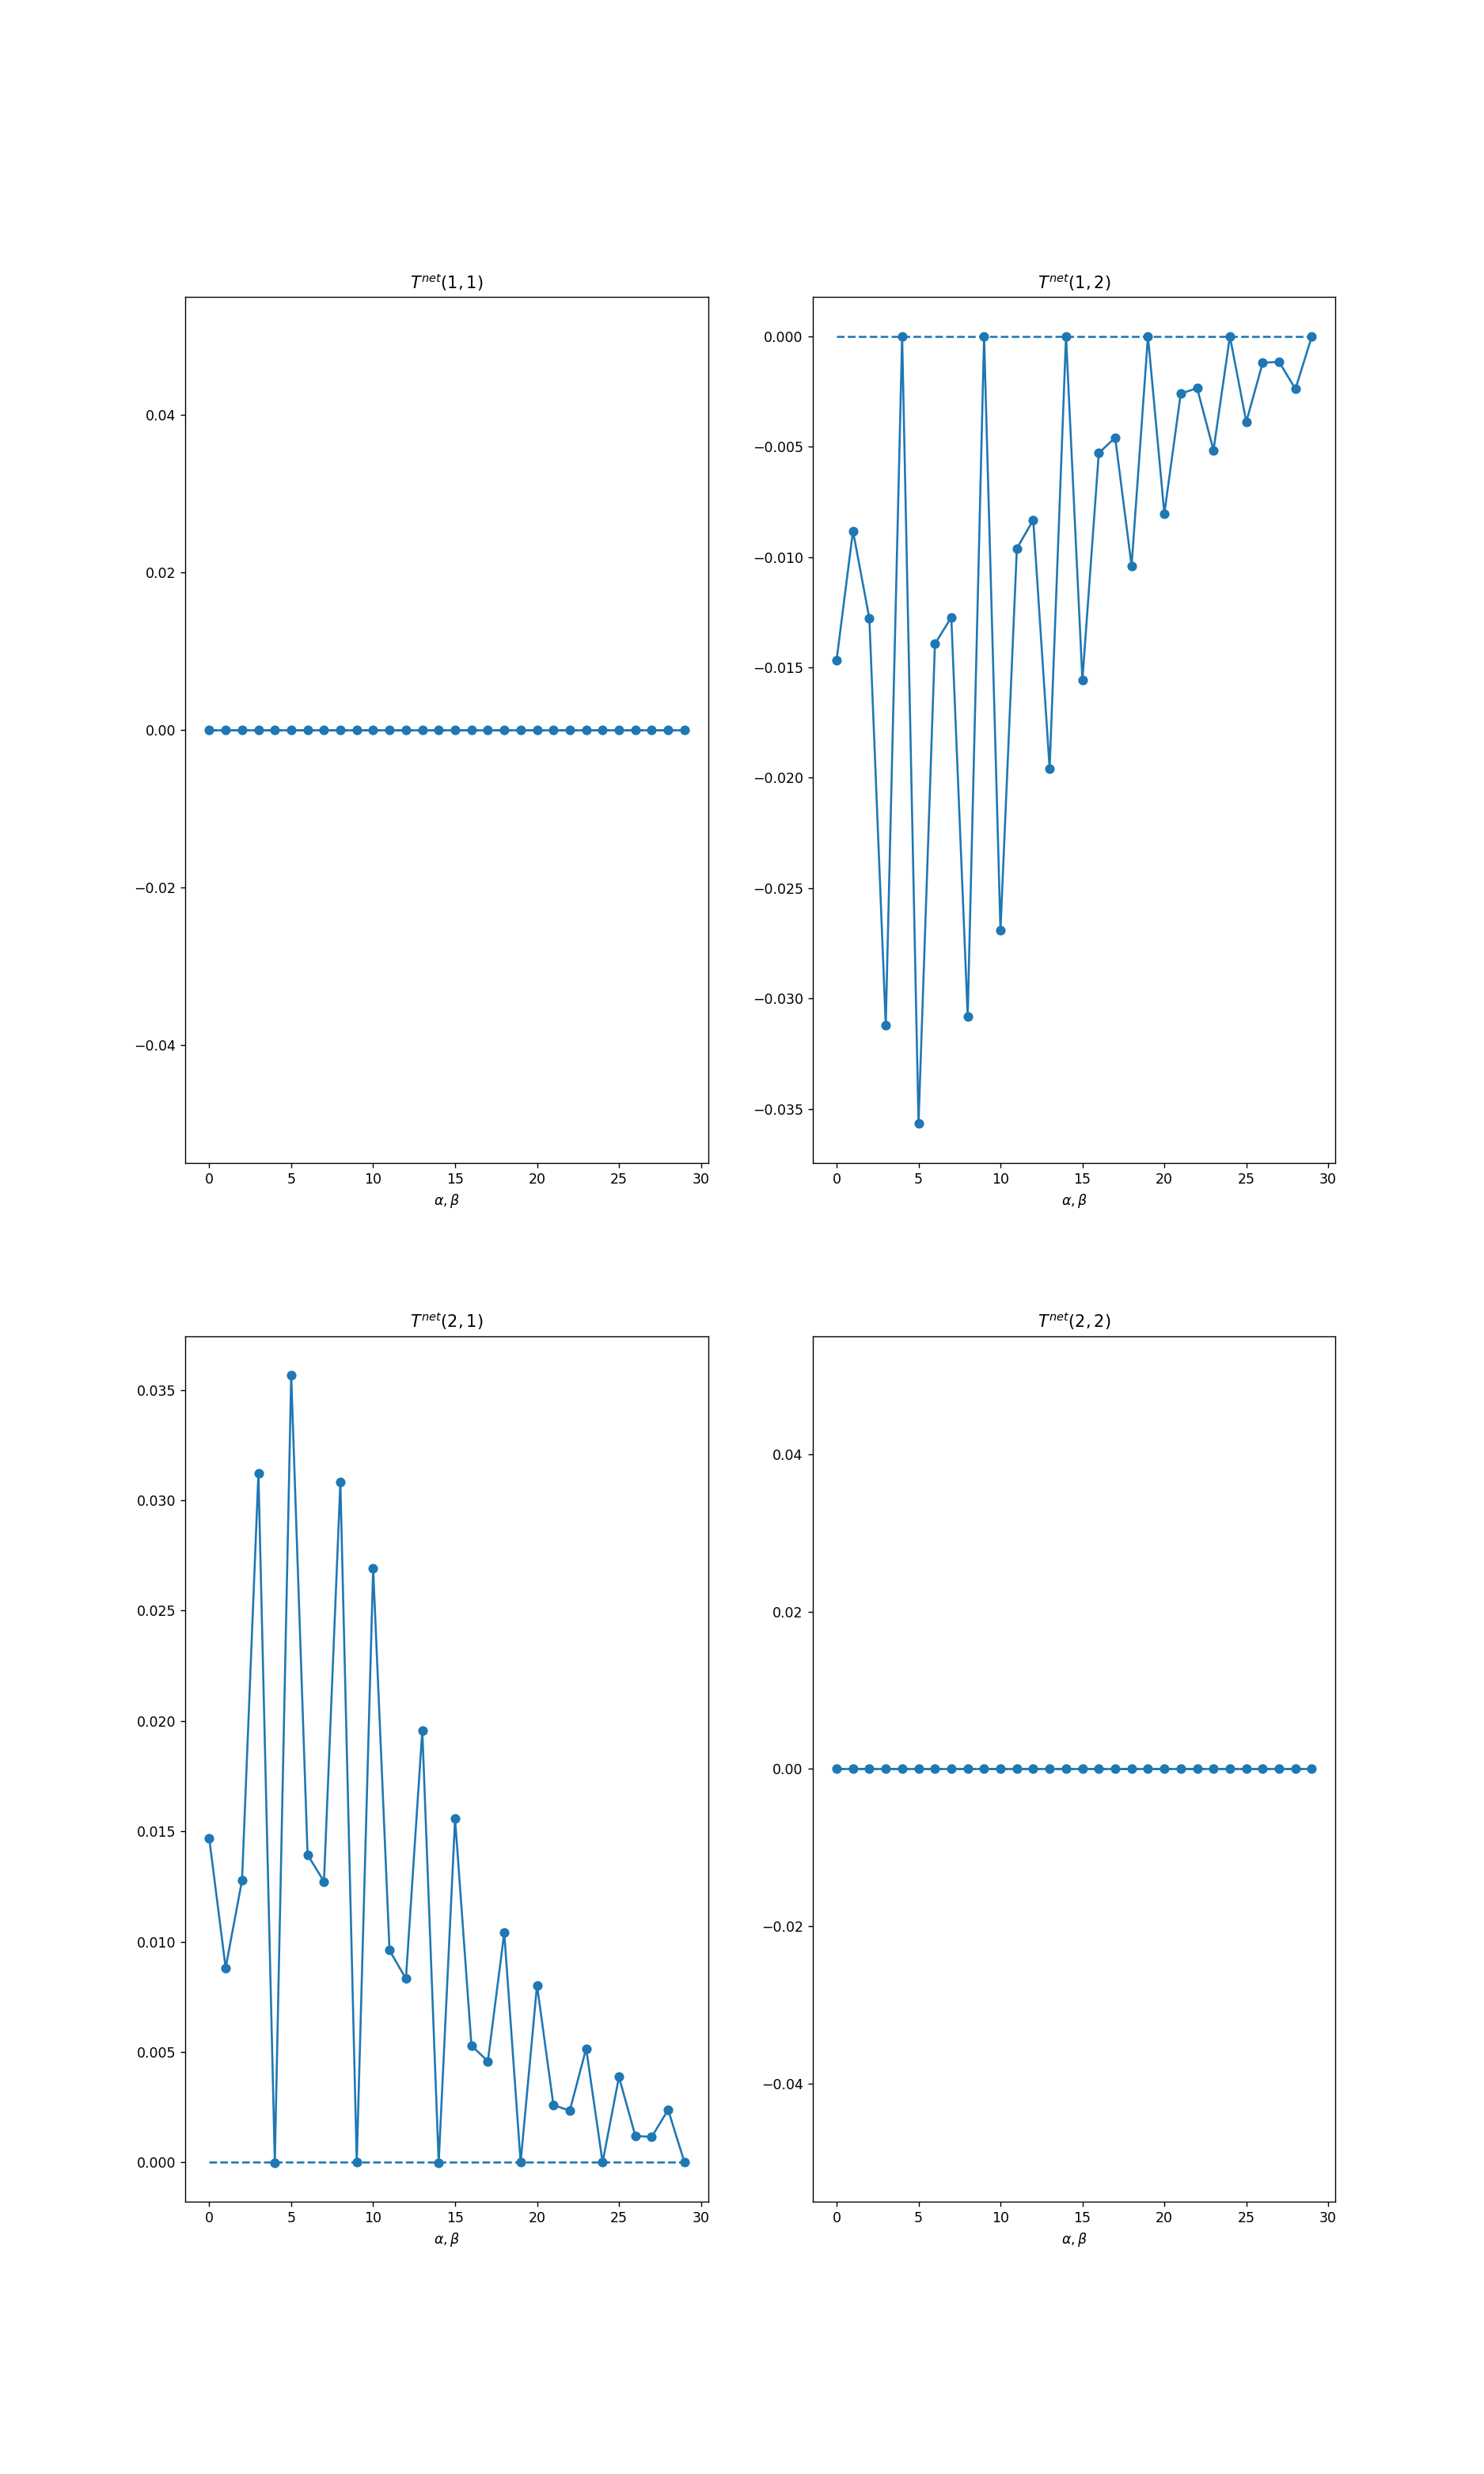

In [11]:
fig, ax = plt.subplots(len(series), len(series), figsize=(15, 25))
for i in range(len(series)):
    for j in range(len(series)):
        ax[i,j].plot(range_t, transfer_matrix_series[:,i,j], 'o-')
        ax[i,j].hlines(0, 0, np.max(range_t), linestyles='dashed')
        ax[i,j].set_xlabel(r'$\alpha, \beta$')
        title = i+1, j+1
        ax[i,j].set_title('$T^{net}$' + f'${title}$')

The graphs show the [net transfer entropy] ($T^{net}_{i,j} = T_{i \rightarrow j} - T_{j \rightarrow i}$) for different lags (0 to 30). Based on the graph, the most apparent result will be expected at [lag 5]. 

In [15]:
x1n = x1[:,:]
x2n = x2[:,:]

size = 4 #bin size in estimating the PDF for [transfer entropy] calculation. 
past = 5 #lag number to calculate the transfer entropy. 
win = 100 #window size of the window sliding. 

data_list = {}
series = np.array([x1n, x2n])

for i in range(len(series)):
    for j in range(len(series)):
        entro_list = []
        time_list = []
        for t in tqdm(range(0, len(tdata), 100)): #NOTE: the jump of [100] time step is to make the calculation quick; ideally would be good to be [1]. 
            temp_x1n = x1n[:,t:t+win]
            temp_x2n = x2n[:,t:t+win]
            
            series = np.array([temp_x1n, temp_x2n])
            
            temp_trans = all_cal_transfer(series[i], series[j], size, past, sim)
            #print(x1n)
            entro_list.append(temp_trans)
            time_list.append(tdata[t])
            #print(i, j, t/len(tdata), end='\r')
        entro_list = np.array(entro_list)
        data_list.update({f'{i+1} to {j+1}': entro_list})

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\choongh2\AppData\Local\Temp\ipykernel_4736\469307606.py:113: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\choongh2\AppData\Local\Temp\ipykernel_4736\469307606.py:115: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.57it/s]


<IPython.core.display.Javascript object>


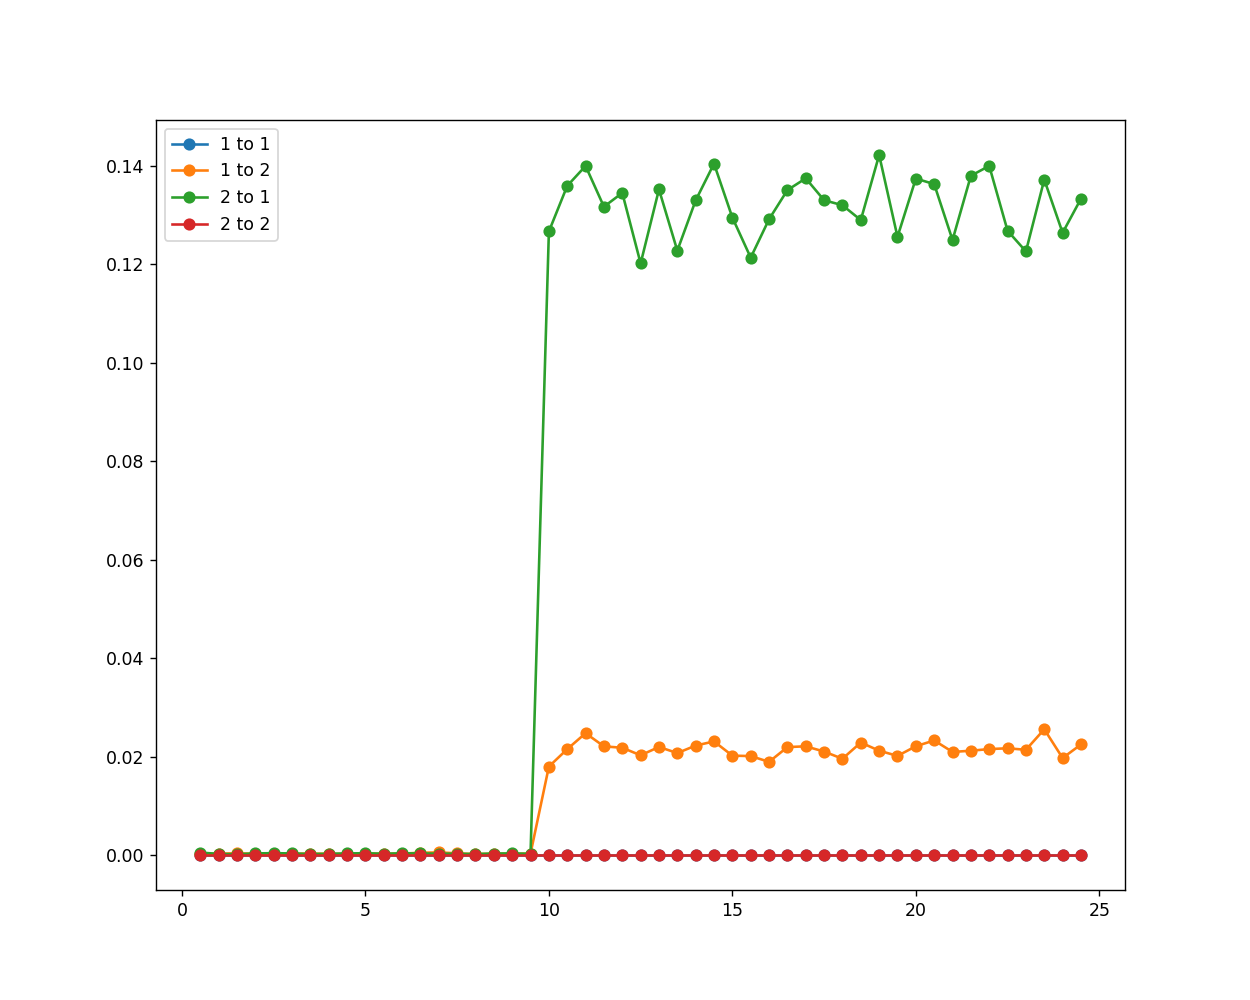

In [16]:
plt.figure(figsize=(10, 8))
for i in range(len(series)):
    for j in range(len(series)):
        plt.plot(np.delete(time_list, 0), np.delete(data_list[f'{i+1} to {j+1}'], 0), 'o-', label=f'{i+1} to {j+1}')
plt.legend(loc='best')
plt.show()
plt.savefig('trans_entro.png')

Due to the previous plot, [lag 5] (shown in the code as: past = 5) is selected to calculate the [transfer entropy] with window sliding. The window slide at the time step of 100 with the size of 100 (sample all the data within the 100 time steps). 

*Reader is encourage to try with different lag of calculating the [transfer entropy] and relate it with the previous plot. 

In [17]:
###calculating the [net transfer entropy] matrix###
size = 4 #bin size for histogram
past = 5 #number of point before the current time

x1n = x1[:,:]
x2n = x2[:,:]

series = np.array([x1n, x2n])
transfer_matrix = np.zeros((len(series), len(series)))

for i in range(0, len(series), 1):
    for j in range(0, len(series), 1):
        temp_trans1 = all_cal_transfer(series[i], series[j], size, past, sim)
        temp_trans2 = all_cal_transfer(series[j], series[i], size, past, sim)
        print(i+1, 'to', j+1, ':', temp_trans1)
        print(j+1, 'to', i+1, ':', temp_trans2)
        transfer_matrix[i, j] = (temp_trans1 - temp_trans2)
        print('1 = x1; 2 = x2')
        print('#'*50)

print(transfer_matrix)
print('1 = x1; 2 = x2')

C:\Users\choongh2\AppData\Local\Temp\ipykernel_4736\469307606.py:113: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)


1 to 1 : -6.398680870333364e-17
1 to 1 : -6.398680870333364e-17
1 = x1; 2 = x2
##################################################


C:\Users\choongh2\AppData\Local\Temp\ipykernel_4736\469307606.py:115: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)


1 to 2 : 0.006838156435657666
2 to 1 : 0.04249867849799825
1 = x1; 2 = x2
##################################################
2 to 1 : 0.04249867849799825
1 to 2 : 0.006838156435657666
1 = x1; 2 = x2
##################################################
2 to 2 : 6.93910354000327e-17
2 to 2 : 6.93910354000327e-17
1 = x1; 2 = x2
##################################################
[[ 0.         -0.03566052]
 [ 0.03566052  0.        ]]
1 = x1; 2 = x2
